In [1]:
#Import libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
#FUNC TO ESTIMATE P-VALUES FROM https://github.com/HurlesGroupSanger/DeNovoWEST

def calc_p0(gl,s_obs):
    '''exact calculate P(S >= sobs | N = 0)P(N = 0)'''
    if s_obs == 0:
        p0 = 1*stats.poisson.pmf(0,gl)
    else:
        p0 = 0
    return(p0)

def calc_p1(gl,s_obs,rates):
    '''exact calculate P(S >= s_obs | N = 1)P(N = 1)'''
    p1c = rates['prob'][rates['weight']>=s_obs].sum()/gl
    p1 = p1c * stats.poisson.pmf(1,gl)
    return(p1)
    
def calc_pn(gl,s_obs,rates,n,nsim,weights_sorted):
    '''simulation to approximate  P(S >= s_obs | N = n)P(N = n)'''
    pndnm = stats.poisson.pmf(n,gl)
    #scaling the number of simulations performed based on the probability of observing n DNMs
    nsim = max([int(round(nsim*pndnm)),10000000])
    #is not possible to observe greater than observed with this number of DNMs set to 0
    if np.sum(weights_sorted[-n:])<s_obs:
        pscore = 0.0
    #if this number of DNMs is always greater than observed set to 1
    elif np.sum(weights_sorted[0:n] >= s_obs):
        pscore = 1.0
    else:
        s = sim_score(gl,s_obs,rates,n,nsim)
        pscore = float(s)/nsim
    pn = pndnm * pscore
    return(pn,nsim)

def sim_score(gl,s_obs,rates,n,nsim):
    '''simulate drawing n random mutations from genes based on mutation probabilites 
        and calculating severity score
    '''
    random.seed(20190409)

    #sample position - sum rates across position and selection position
    posprob = rates.groupby(['pos'])['prob'].sum()
    #randomly select mutations and corresponding weights based on mutation rate probability and sum across genes nsim times
    scores = np.sum(np.random.choice(rates['weight'],(n,nsim),p = rates['prob']/gl),axis = 0)
    #number of times that the gene score is greater than what we observe
    s = np.sum(scores>=s_obs)
    return(s)

def get_pvalue(rates,s_obs,nsim,pvalcap):
    
    '''P(S>=s_obs) under null mutation rate model'''
    #poisson parameter for gene
    gl = rates['prob'].sum()
    exp = np.sum(rates['prob']*rates['weight'])
    #sort weights for use later
    weights_sorted = np.sort(rates['weight'])
    #calculate prob of seeing as or more extreme score if there are 0 mutations or 1 mutations
    p0 = calc_p0(gl,s_obs)
    p1 = calc_p1(gl,s_obs,rates)
    #keep a running p value
    ptot = p0 + p1
    psimtot = 0
    info = "finished all sims"
    #simulate for 2 to 250 mutations in the gene
    for i in range(2,250):
        # set exception if the observed is less than expected (calculating a 1-way p-value)
        if s_obs < exp:
            ptot = 1
            info = "observed < expected, pvalue set at 1"
            sig = 0
            break
        #if p value is over threshold then stop going further
        if ptot > pvalcap:
            info = "pvalue > " + str(pvalcap) + ", stop simulations"
            sig = 0
            break
        #calculate probability of observing gene score as or more extreme as what we observe | i mutations    
        pi,psim = calc_pn(gl,s_obs,rates,i,nsim,weights_sorted)
        #add to running p value
        ptot = ptot + pi
        #keep track of how many simulations are running
        psimtot = psimtot + psim

        #if probability of seeing as or more extreme is small enough (but not 0 which may mean not enough simulations) and
        # the number of mutations is larger than the poisson rate then we can break simulations 
        picdf = 1-stats.poisson.cdf(i,gl)
        if picdf< 10**(-12) and i>gl:
            info = "probability of observing >= " + str(i) + " mutations is too small"
            sig = 1
            break
        #if seeing our observed score is not possible with this number of mutations then break
        if np.sum(weights_sorted[0:i])>s_obs:
            ptot = ptot + picdf
            info ="observed is lower than whole distribution - probability is 1"
            sig = 0
            break
    if ptot == 0:
        ptot = 10**(-14)
        info = "p value was 0, set at 10^-14"
        sig = 1
    info = str(psimtot) + "|" + info
    return(ptot,info,exp, sig)

In [3]:
#FUNC TO ANNOTATE WEIGHTS FROM https://github.com/HurlesGroupSanger/DeNovoWEST

def get_loess_weight_dic(wdicpath,cqs, print_flag):
    '''
    create constrained/unconstrained dictionaries mapping CADD score to LOESS enrichment weight for missense variants
    '''
    wdic = pd.read_table(wdicpath)
    wdic = wdic[wdic.cq.isin(cqs)]
    #separate by missense constraint
    con = wdic[wdic.constrained == True]
    uncon = wdic[wdic.constrained == False]
    #here key is based on shethigh (T/F) + missenseconstrained (T/F) + CADD score rounded to 3 figures
    shethigh_con = dict(zip("True"+ "True" + con.score.round(3).astype(str),con.shethigh))
    shetlow_con = dict(zip("False"+ "True" + con.score.round(3).astype(str),con.shetlow))
    shethigh_uncon = dict(zip("True" + "False" + uncon.score.round(3).astype(str),uncon.shethigh))
    shetlow_uncon = dict(zip("False" + "False" + uncon.score.round(3).astype(str),uncon.shetlow))
    #merge dictionaries into one
    alldic = {**shethigh_con, **shetlow_con, **shethigh_uncon, **shetlow_uncon}
    shethigh_con_max = con.shethigh.max()
    shetlow_con_max = con.shetlow.max()
    shethigh_uncon_max = uncon.shethigh.max()
    shetlow_uncon_max = uncon.shetlow.max()
    caddmax = wdic.score.max()
    return(alldic,shethigh_con_max,shetlow_con_max,shethigh_uncon_max,shetlow_uncon_max,caddmax)

def get_missense_weights(rates,wdicpath,print_flag):
    '''
    get weights for missense variants
    '''
    cqname = ["missense","missense_variant"]
    wdic,shcm,slcm,shum,slum,caddmax = get_loess_weight_dic(wdicpath,cqname, print_flag)
    if 'weight' in rates.columns:
        # weight column has already been defined, so only replace for consequences under study
        rates['weight'] = np.where(rates.cq.isin(cqname), rates.shethigh.astype(str) + rates.constrained.astype(str) + rates.score.round(3).astype(str), rates['weight'])
    else:
        rates['weight'] = np.where(rates.cq.isin(cqname), rates.shethigh.astype(str) + rates.constrained.astype(str) + rates.score.round(3).astype(str), 'NaN')
    #when cadd score exceeds bin replace with max for that subset
    rates['weight'] = np.where(rates.cq.isin(cqname), rates['weight'].map(wdic), rates['weight'])
    rates['weight'] = np.where((rates.constrained == True)  & (rates.shethigh == True) & (rates.score > caddmax) & (rates.cq.isin(cqname)), shcm, rates['weight'])
    rates['weight'] = np.where((rates.constrained == True)  & (rates.shethigh == False) & (rates.score > caddmax) & (rates.cq.isin(cqname)), slcm, rates['weight'])
    rates['weight'] = np.where((rates.constrained == False)  & (rates.shethigh == True) & (rates.score > caddmax) & (rates.cq.isin(cqname)), shum, rates['weight'])
    rates['weight'] = np.where((rates.constrained == False)  & (rates.shethigh == False) & (rates.score > caddmax) & (rates.cq.isin(cqname)), slum, rates['weight'])
    return(rates)
    
def get_nonsense_weights(rates,wdicpath, print_flag):
    '''
    get weights for nonsense variants
    '''
    cqname = ["nonsense","stop_gained"]
    wdic,shcm,slcm,shum,slum,caddmax = get_loess_weight_dic(wdicpath,cqname, print_flag)
    if 'weight' in rates.columns:
        # weight column has already been defined, so only replace for consequences under study
        rates['weight'] = np.where(rates.cq.isin(cqname), rates.shethigh.astype(str) + rates.constrained.astype(str) + rates.score.round(3).astype(str), rates['weight'])
    else:
        rates['weight'] = np.where(rates.cq.isin(cqname), rates.shethigh.astype(str) + rates.constrained.astype(str) + rates.score.round(3).astype(str), 'NaN')
    rates['weight'] = np.where(rates.cq.isin(cqname), rates['weight'].map(wdic), rates['weight'])
    if print_flag:
        sys.stderr.write('after line two\n{0}\n\n'.format(rates.head()))
    rates['weight'] = np.where((rates.constrained == False)  & (rates.shethigh == True) & (rates.score > caddmax) & (rates.cq.isin(cqname)), shum, rates['weight'])
    rates['weight'] = np.where((rates.constrained == False)  & (rates.shethigh == False) & (rates.score > caddmax) & (rates.cq.isin(cqname)), slum, rates['weight'])
    return(rates)

def get_other_weight_dic(wdicpath):
    '''
    get weight dic for non missense variants
    '''
    wdic = pd.read_table(wdicpath)
    wdic = wdic[wdic.cq.isin(["synonymous","splice_lof","inframe","frameshift"])]
    shethigh = dict(zip("True"+ "False" + wdic.cq,wdic.shethigh))
    shetlow = dict(zip("False"+ "False" + wdic.cq,wdic.shetlow))
    alldic = {**shethigh, **shetlow}
    return(alldic)

def get_other_weights(rates,wdicpath):
    '''
    get weights for non missense variants - just enrichment of entire class as opposed to stratified by CADD
    '''
    othercq = ["synonymous","splice_lof","inframe","frameshift"]
    con= get_other_weight_dic(wdicpath)
    rates.weight.loc[rates.cq.isin(othercq)] = rates.shethigh.astype(str) + rates.constrained.astype(str) + rates.cq
    rates.weight.replace(con,inplace=True)
    return(rates)

def get_indel_weights(wdicpath):
    wdic = pd.read_table(wdicpath)
    indel_weights = wdic[wdic.cq.str.contains("frame")]
    return(indel_weights)

def fix_consequences(denovos):
    '''
    function to consolidate consequences across cohorts
    '''
    cdic = {'cq':{"frameshift_variant":"frameshift","inframe_insertion":"inframe","inframe_deletion":"inframe","missense_variant":"missense",'nonsense_variant':'nonsense', "stop_gained":"nonsense","synonymous_variant":"synonymous","splice_acceptor_variant":"splice_lof","splice_lof_variant":"splice_lof","splice_donor_variant":"splice_lof","splice_region_variant":"splice_region","conserved_exon_terminus_variant":"splice_lof"}}
    denovos = denovos[denovos.consequence.isin(cdic['cq'].keys())]
    denovos['cq'] = denovos['consequence']
    denovos = denovos.replace(cdic)
    return(denovos)

def get_weights(rates,wdicpath,print_flag):
    '''
    given rates df get weights columns using con, uncon dictionaries mapping to enrichment weights
    '''
    rates = fix_consequences(rates)
    rates = get_missense_weights(rates,wdicpath, print_flag)
    rates = get_nonsense_weights(rates,wdicpath, print_flag)
    rates = get_other_weights(rates,wdicpath)
    indel_weights = get_indel_weights(wdicpath)
    return(rates,indel_weights)

In [4]:
#Load SGE data

## Read file
sge_lfc = pd.read_csv('/Users/dj14/Desktop/Supp_Table_5.txt', sep='\t', low_memory=False, dtype={'VCF_Hg38_position':int})

#Make a copy of df
sge_lfc_snv = sge_lfc.copy()

#Rename columns to be used for merging with the 'rates' df
sge_lfc_snv = sge_lfc_snv.rename(columns={'VCF_Hg38_position':'pos', 'VCF_Ref':'ref','VCF_Alt':'alt'})

In [5]:
#Clinical variants from DDX3X paper
clinical_var = pd.read_csv('/Users/dj14/Downloads/media-6.txt', sep='\t')
clinical_var = clinical_var.rename(columns={'hg38_pos':'pos'})
clinical_var_female = clinical_var[(clinical_var['sex']=='female') & (clinical_var['inheritance']=='denovo')]

In [6]:
#Probabilities of mutations in DDX3X
ddx3x_b38_rates = pd.read_csv('/Users/dj14/Downloads/DDX3_B38_rates.txt', sep='\t', low_memory=False, dtype={'pos':int})

#Annotate LFC with rates
sge_lfc_snv = sge_lfc_snv.merge(ddx3x_b38_rates, on=['pos','ref','alt'], how='left')

#Check positions without 'probabilities' from rates
print(sge_lfc_snv.prob.value_counts().sum()-ddx3x_b38_rates.prob.value_counts().sum())

#Exclude positions without prob.
sge_lfc_snv_prob = sge_lfc_snv[sge_lfc_snv.prob.notna()]

#Change effect direction
sge_lfc_snv_prob['LFC15_positive'] = sge_lfc_snv_prob['D15_combined_LFC']*(-1)

#Normalize from 0 to 1
sge_lfc_snv_prob['LFC15_norm'] = (sge_lfc_snv_prob.D15_combined_LFC-min(sge_lfc_snv_prob.D15_combined_LFC))/(max(sge_lfc_snv_prob.D15_combined_LFC)-min(sge_lfc_snv_prob.D15_combined_LFC))
sge_lfc_snv_prob['LFC15_norm_positive'] = (sge_lfc_snv_prob.LFC15_positive-min(sge_lfc_snv_prob.LFC15_positive))/(max(sge_lfc_snv_prob.LFC15_positive)-min(sge_lfc_snv_prob.LFC15_positive))

#Setting unchanged and enriched to zero
sge_lfc_snv_prob['LFC15_zero'] = np.where(sge_lfc_snv_prob['SGE_functional_classification'].isin(['unchanged','enriched']),0,sge_lfc_snv_prob['D15_combined_LFC'])
sge_lfc_snv_prob['LFC15_zero_positive'] = sge_lfc_snv_prob['LFC15_zero']*(-1)

#Setting unchanged and enriched to zero normalized
sge_lfc_snv_prob['LFC15_zero_norm'] = (sge_lfc_snv_prob.LFC15_zero-min(sge_lfc_snv_prob.LFC15_zero))/(max(sge_lfc_snv_prob.LFC15_zero)-min(sge_lfc_snv_prob.LFC15_zero))

-1719


/var/folders/7g/c7z0cx3j1vldxh4kydpfjq7m000lwf/T/ipykernel_19279/1177733250.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sge_lfc_snv_prob['LFC15_positive'] = sge_lfc_snv_prob['D15_combined_LFC']*(-1)
/var/folders/7g/c7z0cx3j1vldxh4kydpfjq7m000lwf/T/ipykernel_19279/1177733250.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sge_lfc_snv_prob['LFC15_norm'] = (sge_lfc_snv_prob.D15_combined_LFC-min(sge_lfc_snv_prob.D15_combined_LFC))/(max(sge_lfc_snv_prob.D15_combined_LFC)-min(sge_lfc_snv_prob.D15_co

In [7]:
#Annotating dfs with weigths
sge_lfc_snv_prob['consequence'] = sge_lfc_snv_prob['cq'] + '_variant'
wdicpath =  '/Users/dj14/weights.txt'

#Get weights
sge_lfc_snv_weight,_= get_weights(sge_lfc_snv_prob,wdicpath,False)
sge_lfc_snv_weight = sge_lfc_snv_weight[sge_lfc_snv_weight.weight.apply(np.isreal)]

#Change name of 'weight' column to avoid conflicts in the 'simulation' func
sge_lfc_snv_weight = sge_lfc_snv_weight.rename(columns={'weight':'weight_dnw'})
sge_lfc_snv_weight = sge_lfc_snv_weight[sge_lfc_snv_weight['weight_dnw'].notna()]

#Annotate clinical variants
clinical_var_female_anno = clinical_var_female.merge(sge_lfc_snv_weight, on=['pos','alt','ref'], how='inner')

/var/folders/7g/c7z0cx3j1vldxh4kydpfjq7m000lwf/T/ipykernel_19279/1866357792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sge_lfc_snv_prob['consequence'] = sge_lfc_snv_prob['cq'] + '_variant'
/Users/dj14/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
def simulation(n_mutations, n_runs, approaches:list=None):

    #Seed for reproducibility
    random.seed(20190409)

    #Approaches to compare
    if approaches==None: approaches = ['weight_dnw','LFC15_norm','LFC15_zero_norm','D15_combined_LFC','LFC15_positive','LFC15_zero','LFC15_zero_positive', 'LFC15_norm_positive']

    results = pd.DataFrame()

    #Create lists to store results
    for approach in approaches:

        #Make a copy of df for modifications
        df_copy = sge_lfc_snv_weight.copy()

        #Change name of the column to match 'get_pvalue' function
        df_copy = df_copy.rename(columns={approach:'weight'})
        
        #Make a copy of df for modifications
        df_copy_patho = clinical_var_female_anno.copy()

        #Change name of the column to match 'get_pvalue' function
        df_copy_patho = df_copy_patho.rename(columns={approach:'weight'})
        
        #Create list to store total significant simulations
        vars()[f'sig_count_{approach}'] = []

        #Number of mutations
        mutations = np.arange(1,n_mutations+1,1)

        for n in mutations:

            #Create a list to store significance (Yes=1/No=0)
            vars()[f'sig_times_{approach}'] = []

            #Number of times to test whether that GSS is significant
            runs = np.arange(n_runs)

            for i in runs:

                #randomly select mutations and corresponding weights based on mutation rate probability and sum across genes nsim times
                s_obs = np.sum(np.random.choice(df_copy_patho['weight'],size=n, replace=True, p = df_copy_patho['prob']/df_copy_patho['prob'].sum()), axis=0)

                #Run get_pvalue
                ptot,_,exp,sig = get_pvalue(df_copy,s_obs,10000,1)

                #Count significant runs
                sig = 1 if ptot < 0.05/(18762*2) else 0

                row = {'approach':approach, 'n_mutations':n, 'run':i, 'obs_w':s_obs, 'exp_w':exp, 'p_value':ptot, 'sig':sig}
                results = results.append(row, ignore_index=True)

                #Store results
                vars()[f'sig_times_{approach}'].append(sig)
            
            #Total significant runs
            vars()[f'sig_count_{approach}'].append(sum(vars()[f'sig_times_{approach}']))
        
        print(approach, vars()[f'sig_count_{approach}'])

    #Plot results
    width=1/(len(mutations)+1)
    for i,approach in enumerate(approaches):
        plt.bar(x=mutations+(width*i), height=vars()[f'sig_count_{approach}'], width=width, label=approach)
    plt.xticks(mutations)
    plt.xlabel('Mutations')
    plt.ylabel('Significant simulations')
    plt.show()

    return results

In [ ]:
def sim_score(rates,n,nsim):
    '''simulate drawing n random mutations from genes based on mutation probabilites 
        and calculating severity score
    '''
    #sample position - sum rates across position and selection position
    posprob = rates.groupby(['pos'])['prob'].sum()
    #randomly select mutations and corresponding weights based on mutation rate probability and sum across genes nsim times, where n = number of mutations and nsim = number of simulaytions (ie 3X100000000)
    
    scores = np.sum(np.random.choice(rates['weight'],(n,nsim),p = rates['prob']/gl),axis = 0)#array storing sum of random scores
    dels = np.sum(np.random.choice(dnms['weight'],(n,nsim),p = dnms['prob']/gldel),axis = 0)#array storing sum of deleterious scores
    #number of times that the random score is greater than the deleterious score
    s = np.sum(dels>=scores)#counts how many times del score is higher than random ("True")
    pscore = float(s)/nsim
    return(pscore)

def sim_score(gl,s_obs,rates,n,nsim):
    '''simulate drawing n random mutations from genes based on mutation probabilites 
        and calculating severity score
    '''
    random.seed(20190409)

    #sample position - sum rates across position and selection position
    posprob = rates.groupby(['pos'])['prob'].sum()
    #randomly select mutations and corresponding weights based on mutation rate probability and sum across genes nsim times
    scores = np.sum(np.random.choice(rates['weight'],(n,nsim),p = rates['prob']/gl),axis = 0)
    #number of times that the gene score is greater than what we observe
    s = np.sum(scores>=s_obs)
    return(s)


In [8]:
def simulation_dist(n_mutations, n_runs, approaches:list=None):

    #Seed for reproducibility
    #random.seed(20190409)

    #Approaches to compare
    if approaches==None: approaches = ['weight_dnw','LFC15_norm','LFC15_zero_norm','D15_combined_LFC','LFC15_positive','LFC15_zero','LFC15_zero_positive', 'LFC15_norm_positive']

    results = pd.DataFrame()

    #Number of times to test whether that GSS is significant
    runs = np.arange(n_runs)

    #Number of mutations
    mutations = np.arange(1,n_mutations+1,1)

    #Create lists to store results
    for approach in approaches:
        
        #Create list to store total significant simulations
        vars()[f'sig_count_{approach}'] = []

        #Make a copy of df for modifications
        df_copy = sge_lfc_snv_weight.copy()

        #Change name of the column to match 'get_pvalue' function
        df_copy = df_copy.rename(columns={approach:'weight'})
        
        #Make a copy of df for modifications
        df_copy_patho = clinical_var_female_anno.copy()

        #Change name of the column to match 'get_pvalue' function
        df_copy_patho = df_copy_patho.rename(columns={approach:'weight'})

        for n in mutations:

            #Create a list to store significance (Yes=1/No=0)
            vars()[f'sig_times_{approach}'] = []

            for i in runs:

                #Sum n random weights or lFC (Simulate observed GSS for n mutations)
                null_dist = np.sum(np.random.choice(df_copy['weight'], (n,10000), replace=True, p=df_copy['prob']/df_copy['prob'].sum()), axis=0)

                #randomly select mutations and corresponding weights based on mutation rate probability and sum across genes nsim times
                patho = np.sum(np.random.choice(df_copy_patho['weight'],(n,10000), replace=True, p = df_copy_patho['prob']/df_copy_patho['prob'].sum()), axis=0)

                #number of times that the gene score is greater than what we observe
                s = np.sum(patho>=null_dist)

                #Medians
                null_median = np.median(null_dist)
                patho_median = np.median(patho)

                _, ptot = stats.wilcoxon(x=list(null_dist), y=list(patho), alternative = 'greater', correction=True)

                #Count significant runs
                sig = 1 if (ptot < 0.05) & (patho_median>null_median) else 0

                row = {'approach':approach, 'n_mutations':n, 'run':i, 'patho>=null':s, 'patho>=null_prop':s/10000, 'null_median':null_median, 'patho_median':patho_median, 'p_value':ptot, 'sig':sig}
                results = results.append(row, ignore_index=True)

                #Store results
                vars()[f'sig_times_{approach}'].append(sig)
        
        #Proportion of significant runs
        vars()[f'sig_count_{approach}'].append(sum(vars()[f'sig_times_{approach}'])/runs)
    
    table_medians =results.groupby(['approach','n_mutations'])['patho>=null_prop'].median()
    table_medians = table_medians.reset_index()
    sns.lineplot(x='n_mutations',y='patho>=null_prop',data=table_medians, hue='approach')
    
    return results

/var/folders/7g/c7z0cx3j1vldxh4kydpfjq7m000lwf/T/ipykernel_19279/1373918347.py:67: RuntimeWarning: invalid value encountered in true_divide
  vars()[f'sig_count_{approach}'].append(sum(vars()[f'sig_times_{approach}'])/runs)


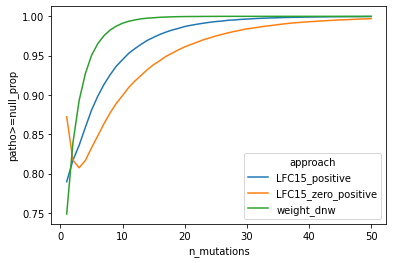

In [12]:
#Run simulation
results = simulation_dist(50,100, ['weight_dnw','LFC15_positive','LFC15_zero_positive'])

In [13]:
results

,approach,n_mutations,run,patho>=null,patho>=null_prop,null_median,patho_median,p_value,sig
0,weight_dnw,1.0,0.0,7474.0,0.7474,0.810895,0.820453,1.0,0.0
1,weight_dnw,1.0,1.0,7432.0,0.7432,0.810895,0.820453,1.0,0.0
2,weight_dnw,1.0,2.0,7423.0,0.7423,0.810895,0.820453,1.0,0.0
3,weight_dnw,1.0,3.0,7518.0,0.7518,0.810895,0.820453,1.0,0.0
4,weight_dnw,1.0,4.0,7519.0,0.7519,0.810895,0.820453,1.0,0.0
...,...,...,...,...,...,...,...,...,...
14995,LFC15_zero_positive,50.0,95.0,9970.0,0.9970,11.182525,28.802394,1.0,0.0
14996,LFC15_zero_positive,50.0,96.0,9968.0,0.9968,11.242830,28.791047,1.0,0.0
14997,LFC15_zero_positive,50.0,97.0,9968.0,0.9968,11.276454,28.897167,1.0,0.0
14998,LFC15_zero_positive,50.0,98.0,9969.0,0.9969,11.200869,28.869023,1.0,0.0
